In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#system parameters
M = 6        #num states
Q = 20       #num time slots
B = 1        #Power constraint
R = 1 / Q    #rate of communicaiton
 
N = 100000    #num training samples
batch_size = 128
epochs = 10


In [35]:
#generating random messages
messages = np.random.randint(0, M, size=N)
S_i = np.eye(M)[messages]  #convert to one-hot

class CommunicationDataset(Dataset):
    def __init__(self, S_i, messages):
        self.S_i = torch.tensor(S_i, dtype=torch.float32)
        self.messages = torch.tensor(messages, dtype=torch.long)
        
    def __len__(self):
        return len(self.S_i)
    
    def __getitem__(self, idx):
        return self.S_i[idx], self.messages[idx]

dataset = CommunicationDataset(S_i, messages)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [36]:
class Autoencoder(nn.Module):
    def __init__(self, M, Q, B):
        super(Autoencoder, self).__init__()
        self.M = M
        self.Q = Q
        self.B = B
        self.encoder = nn.Sequential(
            nn.Linear(M, 128),
            nn.ReLU(),
            nn.Linear(128, M * Q)
        )
        
    def forward(self, input_signal):
        x = self.encoder(input_signal)  
        #reshape
        x = x.view(-1, self.M, self.Q)  
        power = torch.sum(x ** 2, dim=(1, 2), keepdim=True) / self.Q
        #scale to power and return that
        scaling_factor = torch.sqrt(power / self.B)
        return x / scaling_factor
        
#fn describing the system model
def channel_layer(x, s):
    s_t = s.unsqueeze(1)  #(batch_size, 1, M)
    y_signal = torch.bmm(s_t, x)  #(batch_size, 1, Q)
    #add gaussian
    noise = torch.randn_like(y_signal) 
    return y_signal + noise

class Autodecoder(nn.Module):
    def __init__(self, M, Q):
        super(Autodecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(Q, 128),
            nn.ReLU(),
            nn.Linear(128, M)
        )
        
    def forward(self, y):
        return self.decoder(y)

class EndToEndModel(nn.Module):
    def __init__(self, M, Q, B):
        super(EndToEndModel, self).__init__()
        self.autoencoder = Autoencoder(M, Q, B)
        self.autodecoder = Autodecoder(M, Q)
        
    def forward(self, s):
        x = self.autoencoder(s)
        y = channel_layer(x, s)
        return self.autodecoder(y)


In [37]:
#can change to cuda
device = 'cpu'

model = EndToEndModel(M, Q, B).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_history = []

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 0.0213
Epoch 2/10, Loss: 0.0142
Epoch 3/10, Loss: 0.0115
Epoch 4/10, Loss: 0.0105
Epoch 5/10, Loss: 0.0103
Epoch 6/10, Loss: 0.0102
Epoch 7/10, Loss: 0.0088
Epoch 8/10, Loss: 0.0086
Epoch 9/10, Loss: 0.0085
Epoch 10/10, Loss: 0.0076


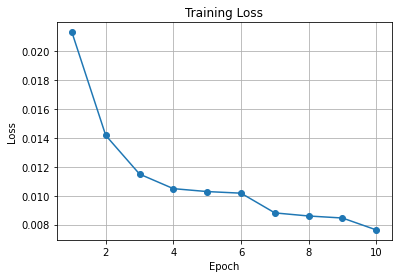

In [38]:
plt.figure()
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


In [39]:
#making test data
N_test = 1000
messages_test = np.random.randint(0, M, size=N_test)
S_i_test = np.eye(M)[messages_test]

S_i_test_tensor = torch.tensor(S_i_test, dtype=torch.float32).to(device)
messages_test_tensor = torch.tensor(messages_test, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(S_i_test_tensor)
    predicted = torch.argmax(outputs, dim=1)
    bit_errors = (predicted != messages_test_tensor).float()
    BER = torch.mean(bit_errors).item()

print(f"Bit Error Rate (BER): {BER:.4f}")


Bit Error Rate (BER): 0.0000


In [40]:
with torch.no_grad():
    inputs = torch.tensor(S_i[:10], dtype=torch.float32).to(device)
    x = model.autoencoder(inputs)
    average_power = torch.mean(torch.sum(x ** 2, dim=(1, 2)) / Q).item()
    print(f"Average Power: {average_power:.4f}, Power Constraint: {B}")


Average Power: 1.0000, Power Constraint: 1


In [ ]:
#optional, for tuning params

def train_and_evaluate(M, Q, B, N, epochs):
    messages = np.random.randint(0, M, size=N)
    S_i = np.eye(M)[messages]
    dataset = CommunicationDataset(S_i, messages)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = EndToEndModel(M, Q, B).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    messages_test = np.random.randint(0, M, size=1000)
    S_i_test = np.eye(M)[messages_test]
    S_i_test_tensor = torch.tensor(S_i_test, dtype=torch.float32).to(device)
    messages_test_tensor = torch.tensor(messages_test, dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(S_i_test_tensor)
        predicted = torch.argmax(outputs, dim=1)
        bit_errors = (predicted != messages_test_tensor).float()
        return torch.mean(bit_errors).item()

M_values = [4, 6, 8]
Q_values = [10, 20]
B_values = [0.5, 1, 2]
results = {}

for M in M_values:
    for Q in Q_values:
        for B in B_values:
            print(f"Testing M={M}, Q={Q}, B={B}")
            BER = train_and_evaluate(M, Q, B, N, epochs)
            results[f"M={M}, Q={Q}, B={B}"] = BER

for key, BER in results.items():
    print(f"{key}: BER={BER:.4f}")


Testing M=4, Q=10, B=0.5
Testing M=4, Q=10, B=1
Testing M=4, Q=10, B=2
Testing M=4, Q=20, B=0.5
Testing M=4, Q=20, B=1
Testing M=4, Q=20, B=2
Testing M=6, Q=10, B=0.5
Testing M=6, Q=10, B=1
Testing M=6, Q=10, B=2
Testing M=6, Q=20, B=0.5
Testing M=6, Q=20, B=1
Testing M=6, Q=20, B=2
Testing M=8, Q=10, B=0.5
Testing M=8, Q=10, B=1
Testing M=8, Q=10, B=2
Testing M=8, Q=20, B=0.5
Testing M=8, Q=20, B=1
Testing M=8, Q=20, B=2
M=4, Q=10, B=0.5: BER=0.0760
M=4, Q=10, B=1: BER=0.0160
M=4, Q=10, B=2: BER=0.0000
M=4, Q=20, B=0.5: BER=0.0090
M=4, Q=20, B=1: BER=0.0000
M=4, Q=20, B=2: BER=0.0000
M=6, Q=10, B=0.5: BER=0.1360
M=6, Q=10, B=1: BER=0.0420
M=6, Q=10, B=2: BER=0.0000
M=6, Q=20, B=0.5: BER=0.0340
M=6, Q=20, B=1: BER=0.0010
M=6, Q=20, B=2: BER=0.0010
M=8, Q=10, B=0.5: BER=0.2150
M=8, Q=10, B=1: BER=0.0540
M=8, Q=10, B=2: BER=0.0080
M=8, Q=20, B=0.5: BER=0.0660
M=8, Q=20, B=1: BER=0.0030
M=8, Q=20, B=2: BER=0.0000
